In [3]:
!jt -t grade3

# Линейные модели, SVM и деревья решений.<br>
<br><br><br>
# 1. Цель работы
изучение линейных моделей, SVM и деревьев решений.
***

# 2. Ход работы<br>
## 2.1. Импорт необходимых библиотек

In [155]:
from operator import itemgetter
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import pandas_profiling
import math
from io import StringIO
from IPython.display import Image
import graphviz
import pydotplus
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score
from sklearn.datasets import *
from typing import Dict, Tuple
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
import seaborn as sns
import matplotlib. pyplot as plt
%matplotlib inline
sns. set(style="ticks")

## 2.2. Выбор датасета для решения задачи классификации или регрессии

In [156]:
# Возьмем датасет для решения задачи классификации
cal = fetch_california_housing()
df = pd.DataFrame(data=np.c_[cal['data'], cal['target']], columns=cal['feature_names']+['target'])
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,target
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


## 2.3. Удаление или заполнение пропусков и кодирование категориальных признаков.

In [157]:
# Проверка на пустые значения
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   MedInc      20640 non-null  float64
 1   HouseAge    20640 non-null  float64
 2   AveRooms    20640 non-null  float64
 3   AveBedrms   20640 non-null  float64
 4   Population  20640 non-null  float64
 5   AveOccup    20640 non-null  float64
 6   Latitude    20640 non-null  float64
 7   Longitude   20640 non-null  float64
 8   target      20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


<AxesSubplot:>

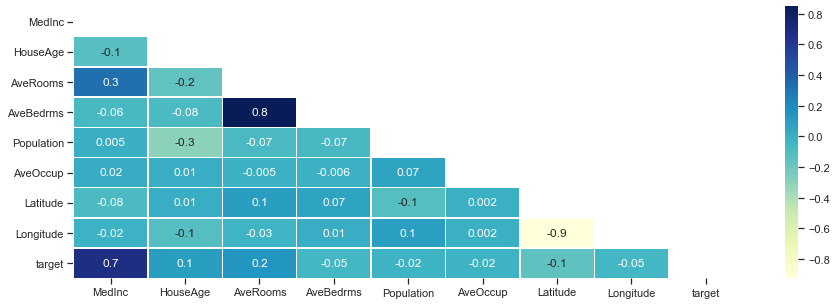

In [158]:
fig, ax = plt.subplots(figsize = (15,5))
mask = np.zeros_like(df.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(df.corr(), cmap='YlGnBu', mask=mask, annot=True, fmt='.1g', linewidths=.5)

<AxesSubplot:xlabel='MedInc', ylabel='target'>

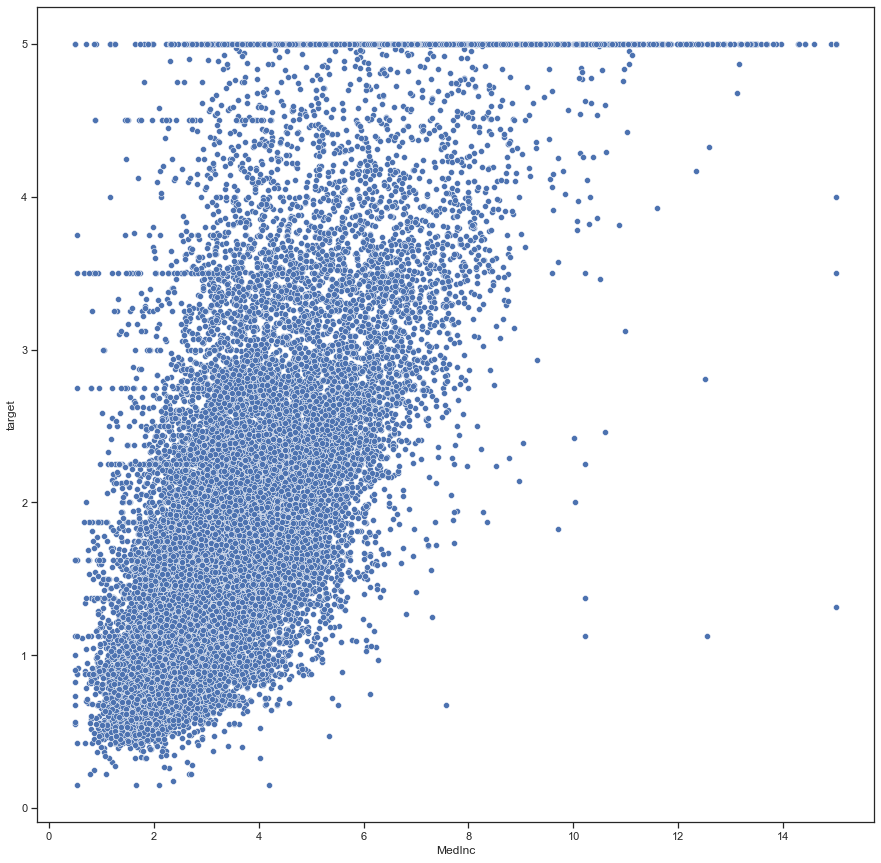

In [159]:
fig, ax = plt.subplots(figsize=(15,15))
sns.scatterplot(data=df, x="MedInc", y="target", ax=ax)

## 2.4. Разделение выборки с использованием метода train_test_split на обучающую и тестовую

In [160]:
x_train, x_test, y_train, y_test = train_test_split(cal.data, cal.target, test_size=0.25, random_state=1)
print(f'x_train\t\ty_train\nСтроки : {x_train.shape[0]}\tСтроки : {y_train.shape[0]}\nСтолбцы : {x_train.shape[1]}\tСтолбцы : --')

x_train		y_train
Строки : 15480	Строки : 15480
Столбцы : 8	Столбцы : --


In [161]:
print(f'x_test\t\ty_test\nСтроки : {x_test.shape[0]}\tСтроки : {y_test.shape[0]}\nСтолбцы : {x_test.shape[1]}\tСтолбцы : --')

x_test		y_test
Строки : 5160	Строки : 5160
Столбцы : 8	Столбцы : --


## 2.5. Обучение моделей
### 2.5.1. Линейные модели
***
#### Аналитическое восстановление зависимости

In [162]:
x_array = df['MedInc'].values
y_array = df['target'].values

In [163]:
#Аналитическое вычисление коэффициентов регрессии
def analytic_regr_coef(x_array : np.ndarray,
    y_array : np.ndarray) -> Tuple[float, float]:
    x_mean = np.mean(x_array)
    y_mean = np.mean(y_array)
    var1 = np.sum([(x-x_mean)**2 for x in x_array])
    cov1 = np.sum([(x-x_mean)*(y-y_mean) for x, y in zip(x_array, y_array)])
    b1 = cov1 / var1
    b0 = y_mean - b1*x_mean
    return b0, b1

In [164]:
b0, b1 = analytic_regr_coef(x_array, y_array)
b0, b1

(0.45085576703268027, 0.41793849201896244)

In [165]:
# Вычисление значений y на основе x для регрессии
def y_regr(x_array : np.ndarray, b0: float, b1: float) -> np.ndarray:
    res = [b1*x+b0 for x in x_array]
    return res

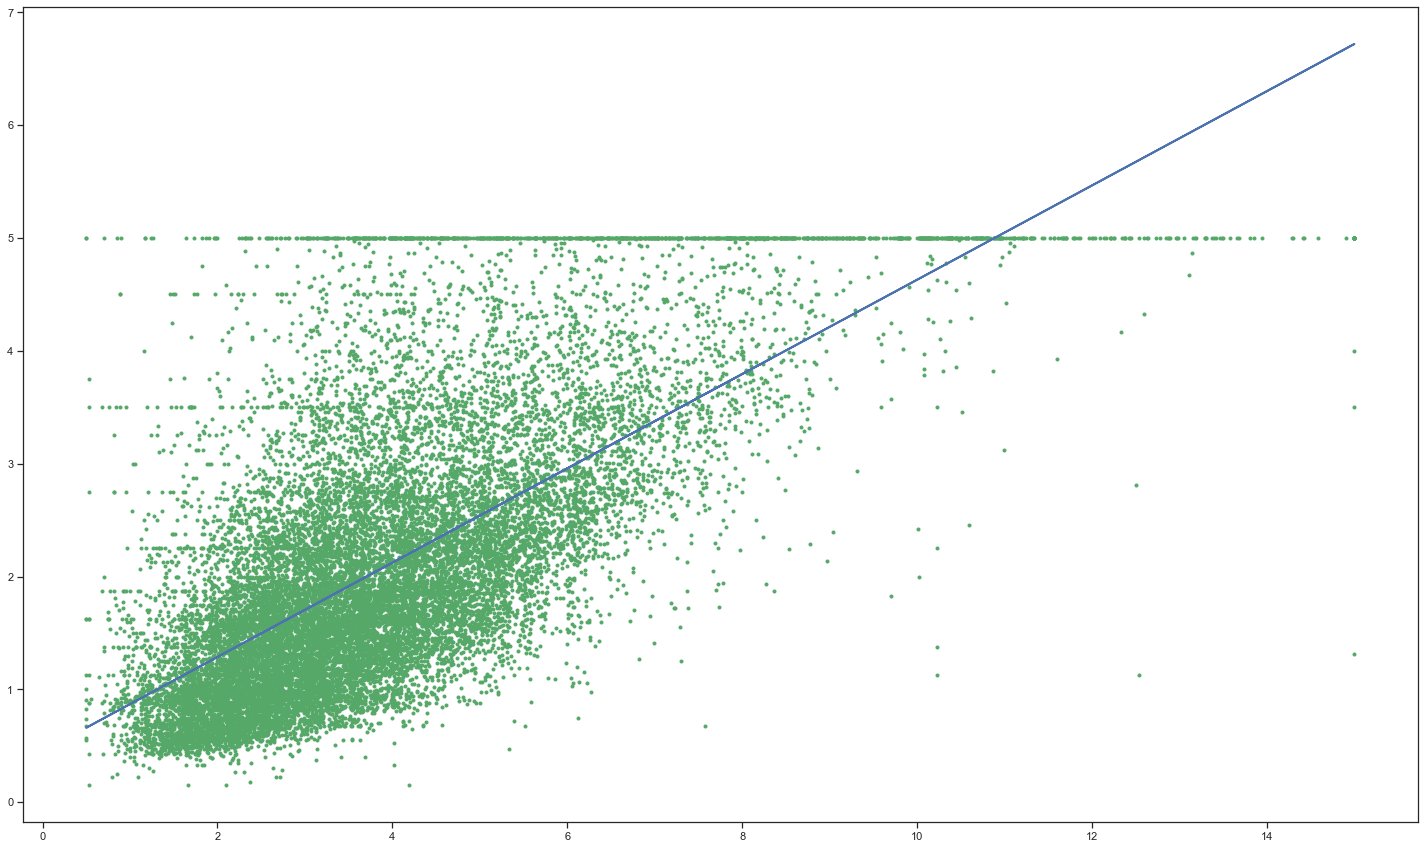

In [166]:
y_array_regr = y_regr(x_array, b0, b1)
fig, ax = plt.subplots(figsize=(25,15))
ax.plot(x_array, y_array, 'g.')
ax.plot(x_array, y_array_regr, 'b', linewidth=2.0)
plt.show()

#### Простейшая реализация градиентного спуска

In [167]:
# Простейшая реализация градиентного спуска
def gradient_descent(x_array : np.ndarray,
                    y_array : np.ndarray,
                    b0_0 : float,
                    b1_0 : float,
                    epochs : int,
                    learning_rate : float = 0.001
                    ) -> Tuple[float, float]:
    # Значения для коэффициентов по умолчанию
    b0, b1 = b0_0, b1_0
    k = float(len(x_array))
    for i in range(epochs):
        # Вычисление новых предсказанных значений
        # используется векторизованное умножение и сложение для вектора и константы
        y_pred = b1 * x_array + b0
        # Расчет градиентов
        # np.multiply - поэлементное умножение векторов
        dL_db1 = (-2/k) * np.sum(np.multiply(x_array, (y_array - y_pred)))
        dL_db0 = (-2/k) * np.sum(y_array - y_pred)
        # Изменение значений коэффициентов:
        b1 = b1 - learning_rate * dL_db1
        b0 = b0 - learning_rate * dL_db0
    # Результирующие значения
    y_pred = b1 * x_array + b0
    return b0, b1, y_pred

In [168]:
def show_gradient_descent(epochs, b0_0, b1_0):
    grad_b0, grad_b1, grad_y_pred = gradient_descent(x_array, y_array, b0_0, b1_0, epochs)
    print(f'\t\t\tb0\t\t\tb1')
    print(f'теоретический\t\t{b0}\t{b1}')
    print(f'градиентный спуск\t{grad_b0}\t{grad_b1}')
    print(f'Разница\t\t\t{abs(b0-grad_b0)}\t{abs(b1-grad_b1)}')
    print(f'\nMSE = {mean_squared_error(y_array_regr, grad_y_pred)}')
    plt.plot(x_array, y_array, 'g.')
    plt.plot(x_array, y_array_regr, 'b', linewidth=2.0)
    plt.plot(x_array, grad_y_pred, 'r', linewidth=2.0)
    plt.show()

			b0			b1
теоретический		0.45085576703268027	0.41793849201896244
градиентный спуск	0.11398891049585097	0.4789917983846716
Разница			0.3368668565368293	0.06105330636570916

MSE = 0.02356334130030826


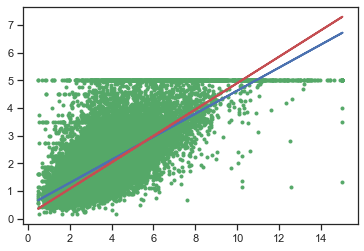

In [169]:
show_gradient_descent(100, 0, 0)

			b0			b1
теоретический		0.45085576703268027	0.41793849201896244
градиентный спуск	0.21125447583768953	0.46832724481210447
Разница			0.23960129119499074	0.05038875279314203

MSE = 0.011149582877403865


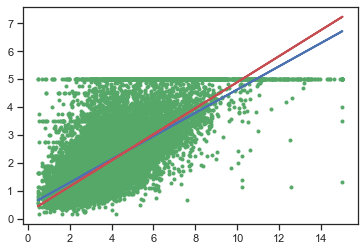

In [170]:
show_gradient_descent(1000, 0, 0)

			b0			b1
теоретический		0.45085576703268027	0.41793849201896244
градиентный спуск	0.44243613352213074	0.4197091620744368
Разница			0.008419633510549529	0.001770670055474377

MSE = 1.3767867818112204e-05


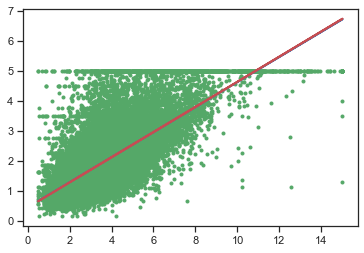

In [171]:
show_gradient_descent(10000, 0, 0)

***
#### Линейная регрессия

In [172]:
x_array_res = x_array.reshape(-1,1)
y_array_res = y_array.reshape(-1,1)

In [173]:
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import *

In [174]:
linear = LinearRegression()
l = linear.fit(x_array_res, y_array_res)
print(f'\t\t\tb0\t\t\tb1')
print(f'теоретический\t{b0}\t{b1}')
print(f'лин. регрессия\t{l.intercept_[0]}\t{l.coef_[0][0]}')
print(f'Разница\t\t{abs(b0-l.intercept_[0])}\t{abs(b1-l.coef_[0][0])}')

			b0			b1
теоретический	0.45085576703268027	0.41793849201896244
лин. регрессия	0.4508557670326785	0.4179384920189629
Разница		1.7763568394002505e-15	4.440892098500626e-16


***
#### Lasso

In [175]:
reg3 = Lasso().fit(x_array.reshape(-1, 1), y_array)
print(f'\t\t\tb0\t\t\tb1')
print(f'теоретический\t{b0}\t{b1}')
print(f'Лассо\t\t{reg3.coef_[0]}\t{reg3.intercept_}')
print(f'Разница\t\t{abs(b0-reg3.coef_[0])}\t{abs(b1-reg3.intercept_)}')

			b0			b1
теоретический	0.45085576703268027	0.41793849201896244
Лассо		0.1408647654838673	1.5233170059994503
Разница		0.309991001548813	1.105378513980488


In [176]:
reg4 = Ridge().fit(x_array.reshape(-1, 1), y_array)
print(f'\t\t\t\tb0\t\t\tb1')
print(f'теоретический\t\t{b0}\t{b1}')
print(f'Гребнеевый регресс\t{reg4.coef_[0]}\t{reg4.intercept_}')
print(f'Разница\t\t\t{abs(b0-reg4.coef_[0])}\t{abs(b1-reg4.intercept_)}')

				b0			b1
теоретический		0.45085576703268027	0.41793849201896244
Гребнеевый регресс	0.4179328816400402	0.4508774829636897
Разница			0.032922885392640044	0.03293899094472724


In [177]:
reg5 = ElasticNet().fit(x_array.reshape(-1, 1), y_array)
print(f'\t\t\tb0\t\t\tb1')
print(f'теоретический\t{b0}\t{b1}')
print(f'Elastic Net\t{reg5.coef_[0]}\t{reg5.intercept_}')
print(f'Разница\t\t{abs(b0-reg5.coef_[0])}\t{abs(b1-reg5.intercept_)}')

			b0			b1
теоретический	0.45085576703268027	0.41793849201896244
Elastic Net	0.24540411273952542	1.1186795859141514
Разница		0.20545165429315485	0.700741093895189


***
### SVR

<AxesSubplot:xlabel='MedInc', ylabel='target'>

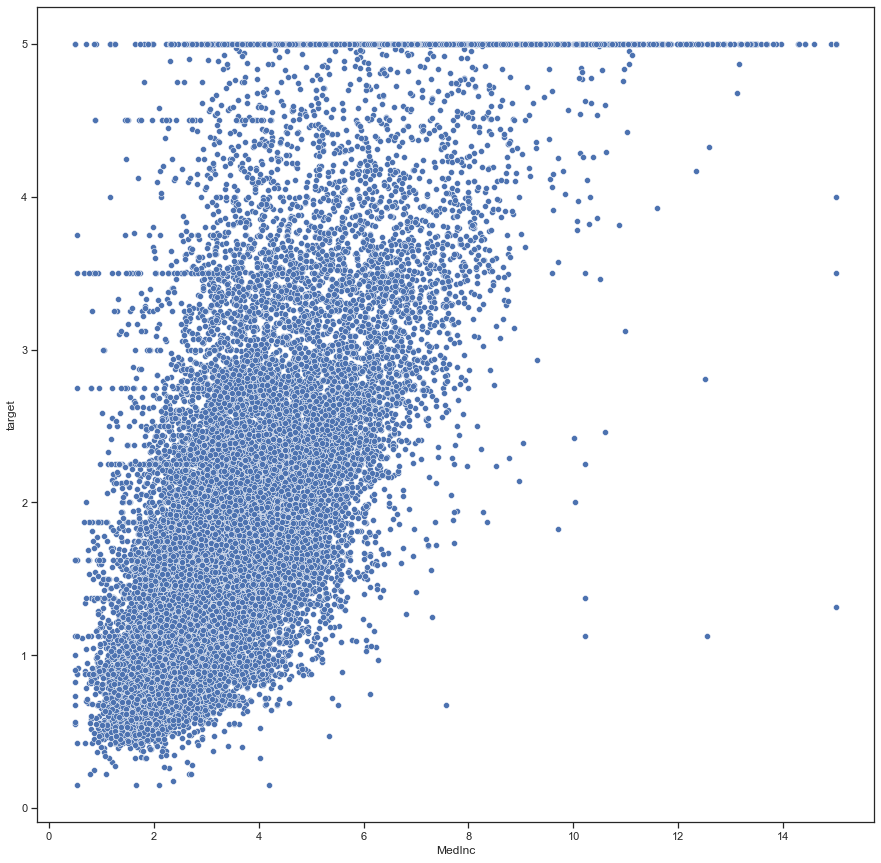

In [178]:
fig, ax = plt.subplots(figsize=(15,15)) 
sns.scatterplot(data=df, x="MedInc", y="target", ax=ax)

In [179]:
def plot_regr(clf, x, y):
    title = clf.__repr__
    clf.fit(x.reshape(-1, 1), y)
    boston_y_pred = clf.predict(x.reshape(-1, 1))
    fig, ax = plt.subplots(figsize=(5,5))
    ax.set_title(title)
    ax.plot(x, y, 'b.')
    ax.plot(x, boston_y_pred, 'ro')
    plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


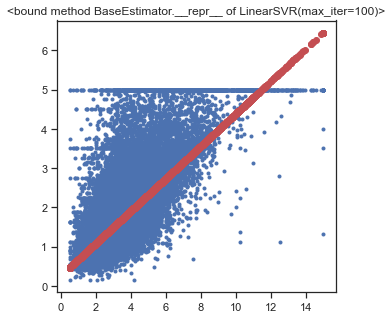

In [180]:
plot_regr(LinearSVR(C=1.0, max_iter=100), x_array, y_array)

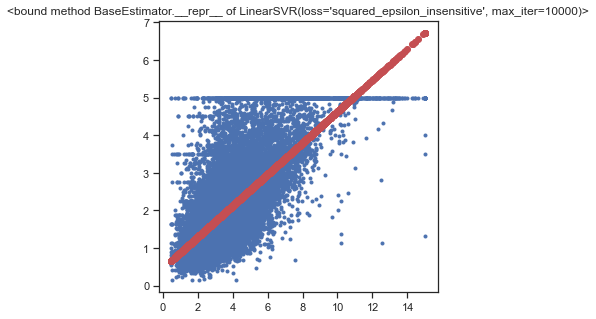

In [181]:
plot_regr(LinearSVR(C=1.0, loss='squared_epsilon_insensitive', max_iter=10000), x_array, y_array)

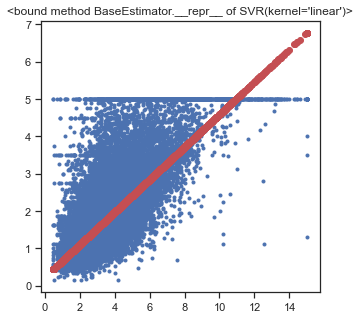

In [182]:
plot_regr(SVR(kernel='linear', C=1.0), x_array, y_array)

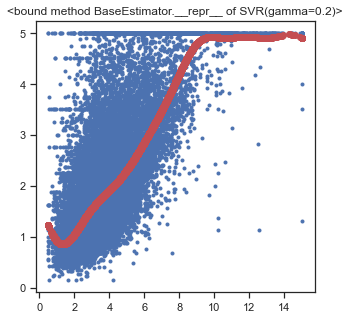

In [183]:
plot_regr(SVR(kernel='rbf', gamma=0.2, C=1.0), x_array, y_array)

***
### SVC

In [184]:
wine = load_wine()
winex = wine.data[:, :2]
winey = wine.target

In [185]:
def make_meshgrid(x, y, h=.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    #Можно проверить все ли метки классов предсказываются
    #print(np.unique(Z))
    out = ax.contourf(xx, yy, Z, **params)
    return out


def plot_cl(clf, x, y):
    title = clf.__repr__
    clf.fit(x, y)
    fig, ax = plt.subplots(figsize=(5,5))
    X0= x[:, 0]
    X1 = y
    xx, yy = make_meshgrid(X0, X1)
    plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
    ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel('Sepal length')
    ax.set_ylabel('Sepal width')
    ax.set_xticks(())
    ax.set_yticks(())
    ax.set_title(title)
    plt.show()

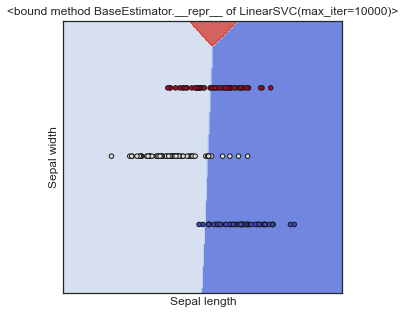

In [186]:
plot_cl(LinearSVC(C=1.0, max_iter=10000), winex, winey)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


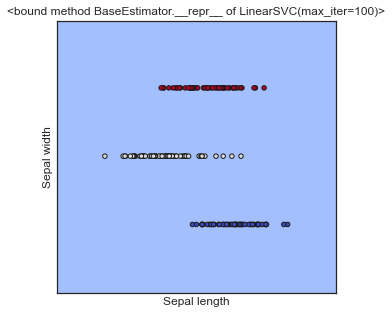

In [187]:
plot_cl(LinearSVC(C=1.0, max_iter=100), winex, winey)

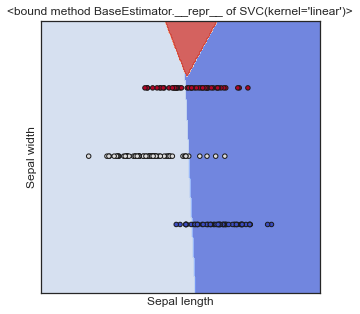

In [188]:
plot_cl(SVC(kernel='linear', C=1.0), winex, winey)

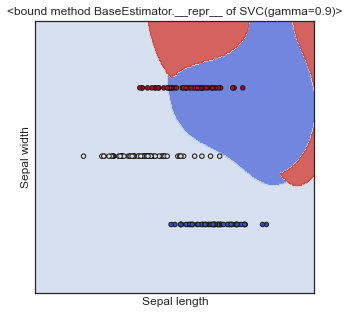

In [189]:
plot_cl(SVC(kernel='rbf', gamma=0.9, C=1.0), winex, winey)

***
### Деревья

In [190]:
def accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray) -> Dict[int, float]:
    """
    Вычисление метрики accuracy для каждого класса
    y_true - истинные значения классов
    y_pred - предсказанные значения классов
    Возвращает словарь: ключ - метка класса, 
    значение - Accuracy для данного класса
    """
    # Для удобства фильтрации сформируем Pandas DataFrame 
    d = {'t': y_true, 'p': y_pred}
    df = pd.DataFrame(data=d)
    # Метки классов
    classes = np.unique(y_true)
    # Результирующий словарь
    res = dict()
    # Перебор меток классов
    for c in classes:
        # отфильтруем данные, которые соответствуют 
        # текущей метке класса в истинных значениях
        temp_data_flt = df[df['t']==c]
        # расчет accuracy для заданной метки класса
        temp_acc = accuracy_score(
            temp_data_flt['t'].values, 
            temp_data_flt['p'].values)
        # сохранение результата в словарь
        res[c] = temp_acc
    return res

def print_accuracy_score_for_classes(
    y_true: np.ndarray, 
    y_pred: np.ndarray):
    """
    Вывод метрики accuracy для каждого класса
    """
    accs = accuracy_score_for_classes(y_true, y_pred)
    if len(accs)>0:
        print('Метка \t Accuracy')
    for i in accs:
        print('{} \t {}'.format(i, accs[i]))

#### DecisionTreeClassifier

In [191]:
# Разделим выборку на обучающую и тестовую
wine_X_train, wine_X_test, wine_y_train, wine_y_test = train_test_split(
    wine.data, wine.target, test_size=0.5, random_state=1)
wine_X_train.shape, wine_X_test.shape

((89, 13), (89, 13))

In [192]:
wine_tree_cl_feat_1 = DecisionTreeClassifier(random_state=1).fit(wine_X_train, wine_y_train)
wine_y_test_predict = wine_tree_cl_feat_1.predict(wine_X_test)
wine_y_test_predict.shape

(89,)

In [193]:
print_accuracy_score_for_classes(wine_y_test, wine_y_test_predict)

Метка 	 Accuracy
0 	 0.8181818181818182
1 	 0.8823529411764706
2 	 0.9545454545454546


In [194]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

In [195]:
Image(get_png_tree(wine_tree_cl_feat_1, wine.feature_names), height='70%')

InvocationException: GraphViz's executables not found

#### DecisionTreeRegressor

In [196]:
# Визуализация дерева
def get_png_tree(tree_model_param, feature_names_param):
    dot_data = StringIO()
    export_graphviz(tree_model_param, out_file=dot_data, feature_names=feature_names_param,
                    filled=True, rounded=True, special_characters=True)
    graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
    return graph.create_png()

In [197]:
california_tree_regr = DecisionTreeRegressor(random_state=1)
california_tree_regr.fit(wine_X_train, wine_y_train)
done = california_tree_regr.predict(wine_X_test)